Shapes: {'df5': (689, 16), 'df4': (365, 6), 'df3': (30, 3), 'df2': (346, 31)}


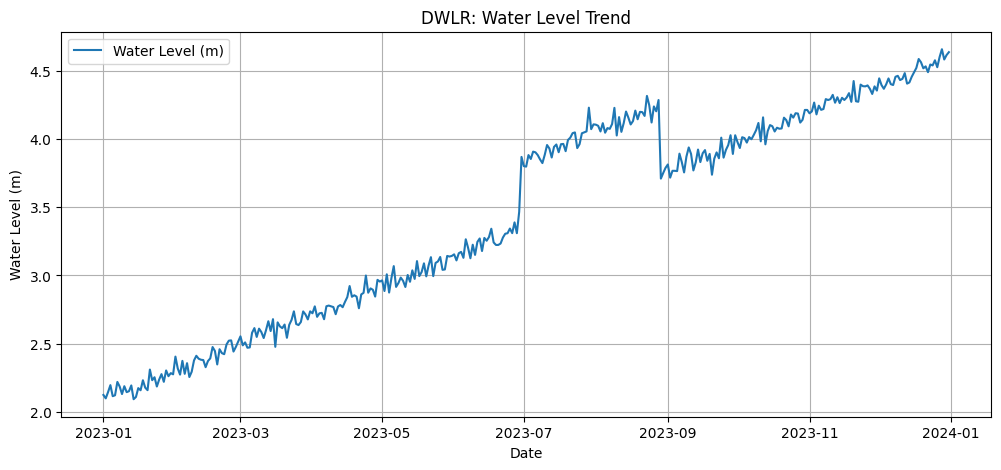

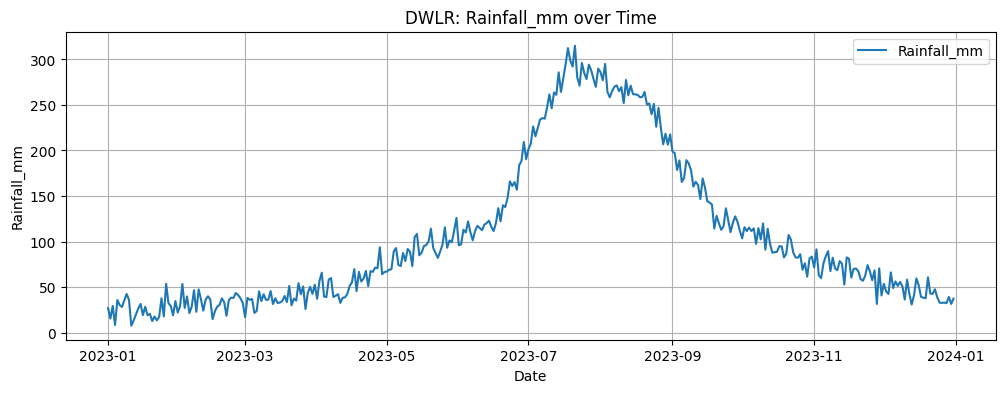

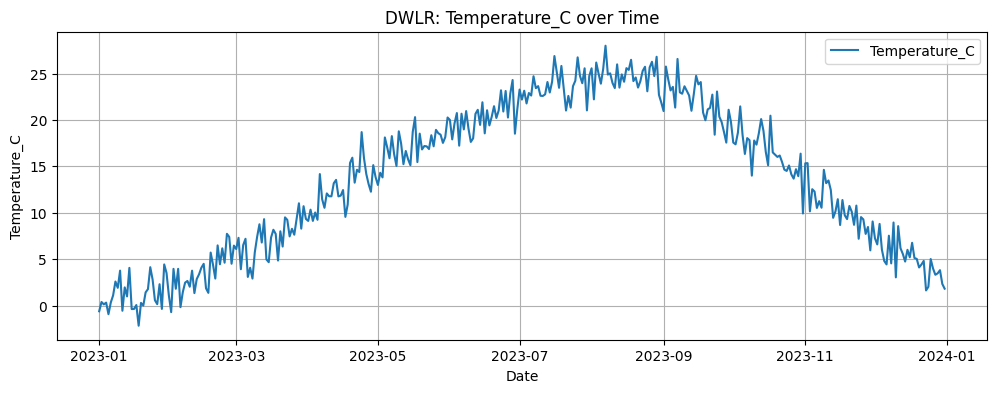

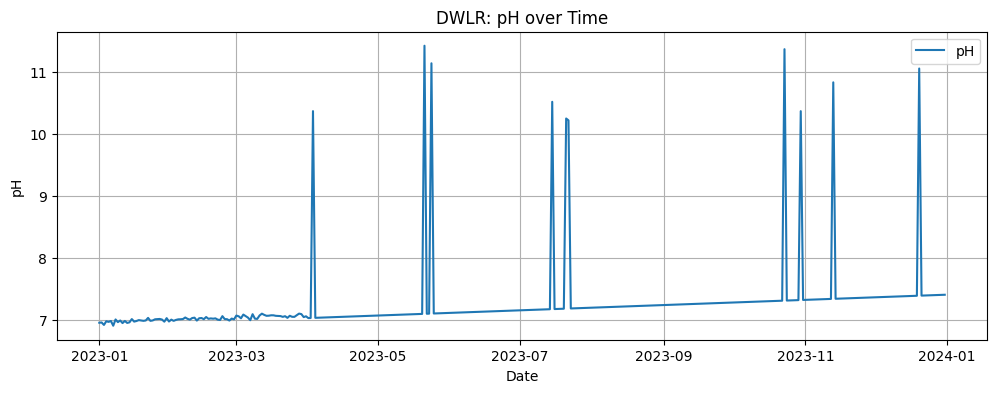

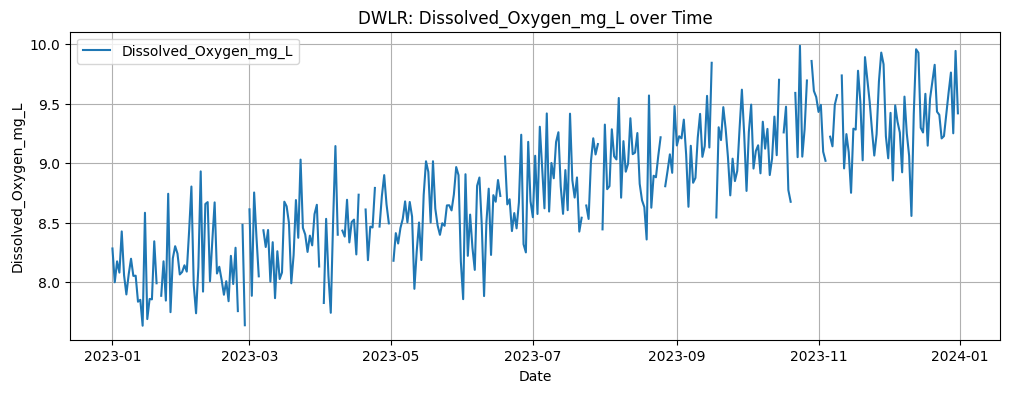

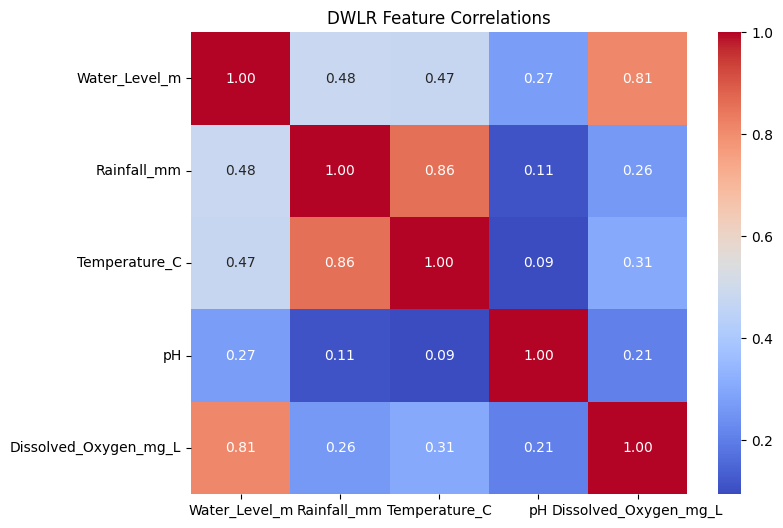

Linear Regression -> RMSE: 0.3526, R²: -7.0543


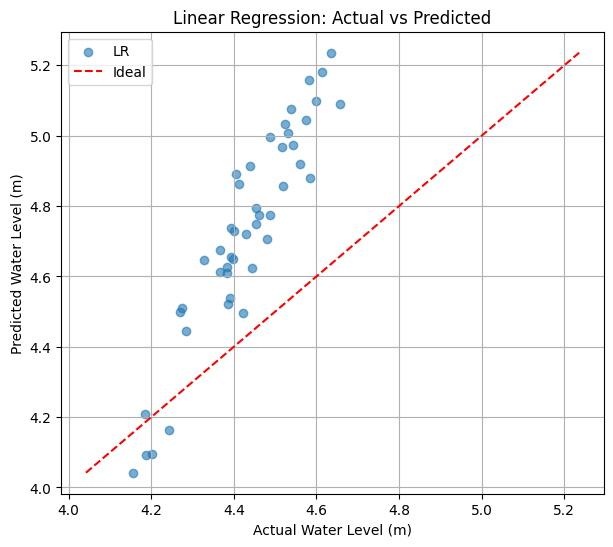

XGBoost -> RMSE: 0.3315, R²: -6.1174


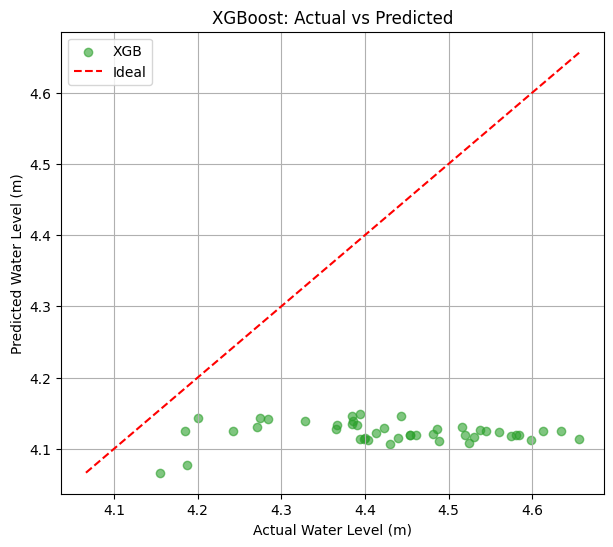

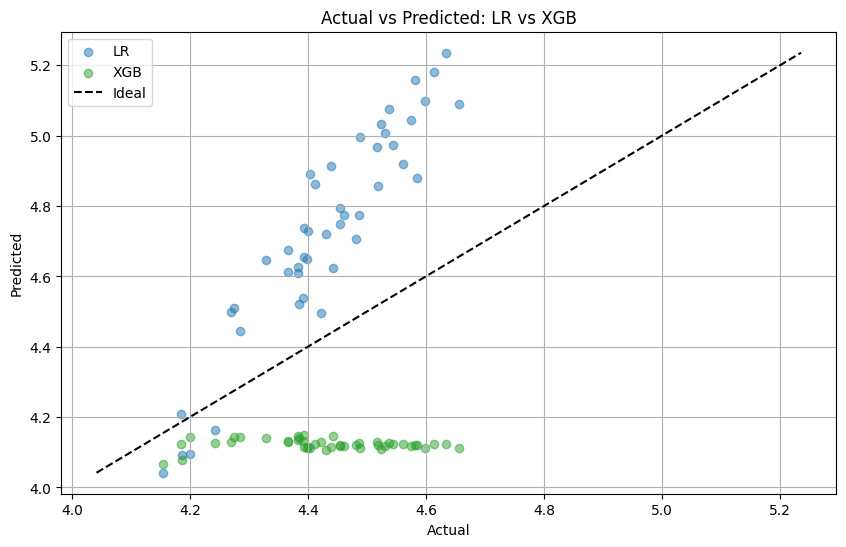

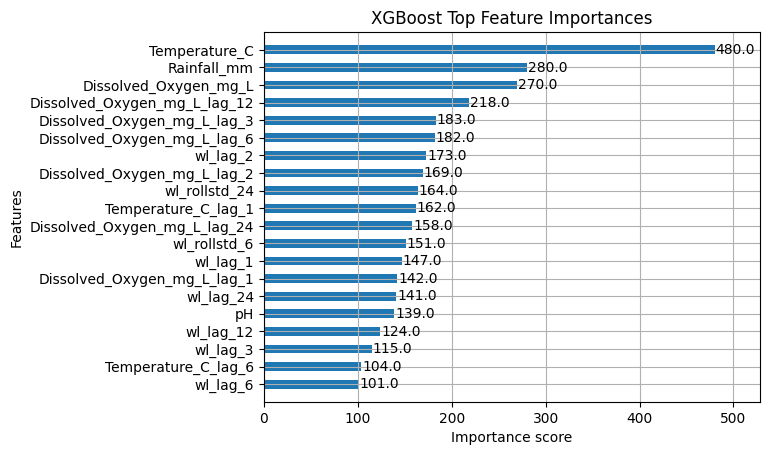

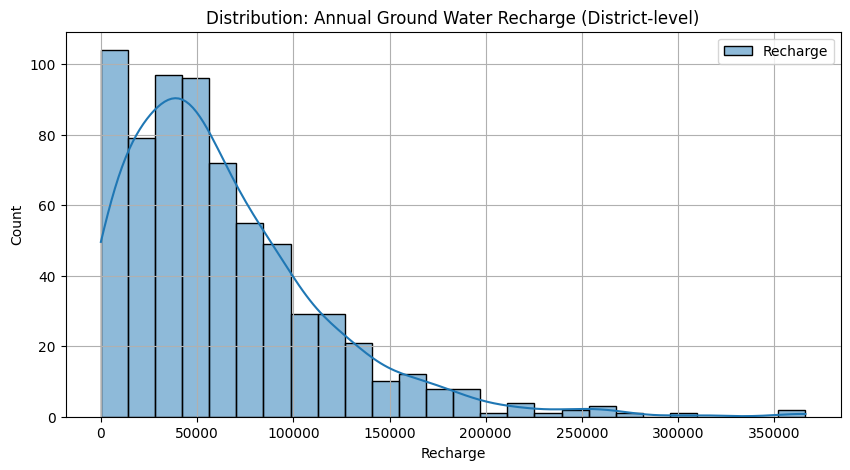

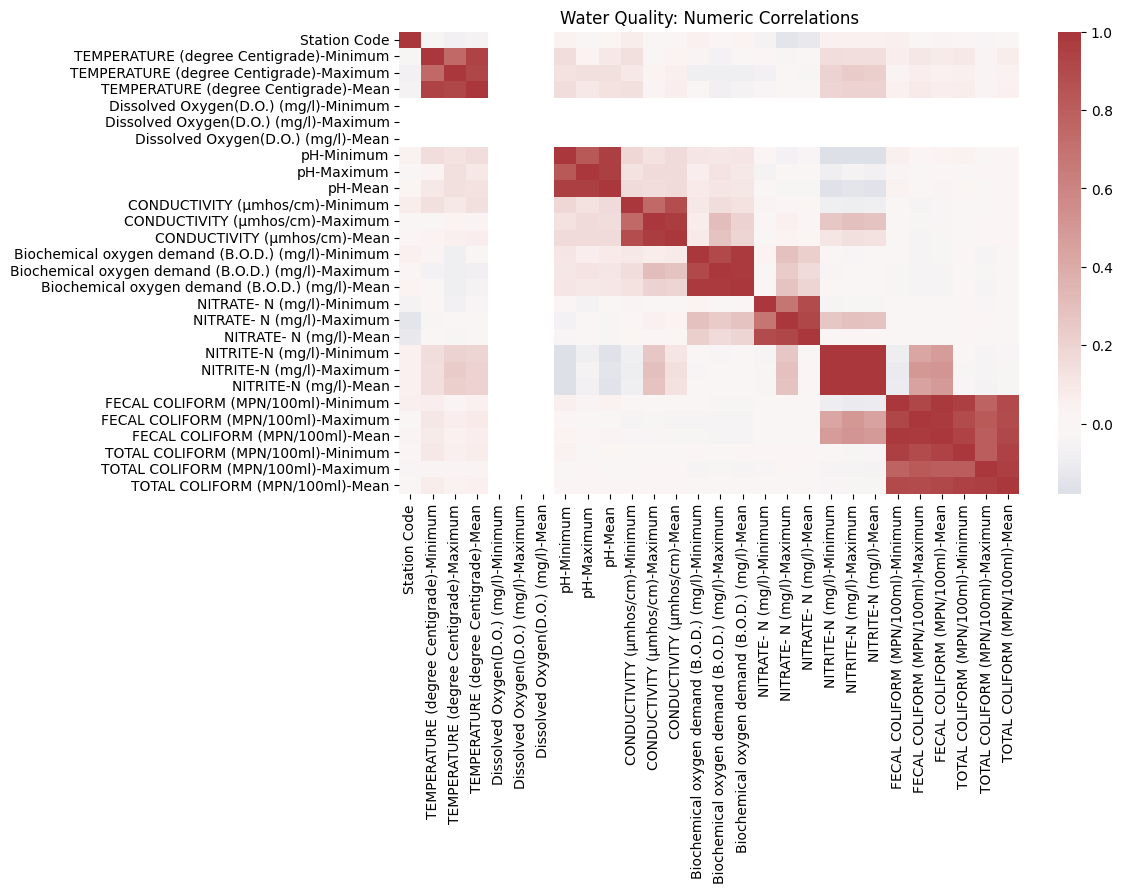

In [2]:
# !pip install pandas numpy matplotlib seaborn scikit-learn xgboost shap joblib

import pandas as pd, numpy as np, joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import shap
import json

# 1) Load datasets (adjust paths if needed)
df5 = pd.read_csv('/workspaces/DWLR-Groundwater-Project/Dynamic_2017_2_0.csv')  # Annual/district groundwater balance
df4 = pd.read_csv('/workspaces/DWLR-Groundwater-Project/DWLR_Dataset_2023.csv')  # Daily DWLR time series
df3 = pd.read_excel('/workspaces/DWLR-Groundwater-Project/State Ground Water Level Information.xlsx', sheet_name='Sheet1')  # State meta
df2 = pd.read_csv('/workspaces/DWLR-Groundwater-Project/wtrqlty_grndwtr_2008.csv',encoding='latin1')


# 2) Basic inspection
print("Shapes:", {'df5': df5.shape, 'df4': df4.shape, 'df3': df3.shape, 'df2': df2.shape})

# 3) DWLR preprocessing (time series)
dwlr = df4.copy()
dwlr['Date'] = pd.to_datetime(dwlr['Date'])
dwlr = dwlr.sort_values('Date').reset_index(drop=True)

# If single-station data, create a placeholder station_id
dwlr['station_id'] = 0

# 4) Plot raw time trends
plt.figure(figsize=(12,5))
plt.plot(dwlr['Date'], dwlr['Water_Level_m'], label='Water Level (m)', color='tab:blue')
plt.title('DWLR: Water Level Trend')
plt.xlabel('Date'); plt.ylabel('Water Level (m)'); plt.legend(); plt.grid(True)
plt.show()

for col in ['Rainfall_mm','Temperature_C','pH','Dissolved_Oxygen_mg_L']:
    if col in dwlr.columns:
        plt.figure(figsize=(12,4))
        plt.plot(dwlr['Date'], dwlr[col], label=col)
        plt.title(f'DWLR: {col} over Time')
        plt.xlabel('Date'); plt.ylabel(col); plt.legend(); plt.grid(True)
        plt.show()

# 5) Correlation heatmap (DWLR)
plt.figure(figsize=(8,6))
sns.heatmap(dwlr[['Water_Level_m','Rainfall_mm','Temperature_C','pH','Dissolved_Oxygen_mg_L']].corr(), 
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('DWLR Feature Correlations')
plt.show()

# 6) Feature engineering (lags/rolling)
def add_time_features(df, horizon=1, lags=(1,2,3,6,12,24), rolls=(6,24,72)):
    d = df.copy().sort_values(['station_id','Date'])
    # target at t + horizon
    d['target'] = d.groupby('station_id')['Water_Level_m'].shift(-horizon)

    # Lags of water level
    for k in lags:
        d[f'wl_lag_{k}'] = d.groupby('station_id')['Water_Level_m'].shift(k)

    # Rolling stats of water level (use shifted windows to avoid leakage)
    for w in rolls:
        grp = d.groupby('station_id')['Water_Level_m']
        d[f'wl_rollmean_{w}'] = grp.transform(lambda s: s.shift(1).rolling(w, min_periods=max(3, w//3)).mean())
        d[f'wl_rollstd_{w}']  = grp.transform(lambda s: s.shift(1).rolling(w, min_periods=max(3, w//3)).std())
        d[f'wl_rollmin_{w}']  = grp.transform(lambda s: s.shift(1).rolling(w, min_periods=max(3, w//3)).min())
        d[f'wl_rollmax_{w}']  = grp.transform(lambda s: s.shift(1).rolling(w, min_periods=max(3, w//3)).max())

    # Exogenous variables (if present), with lags and rolling windows
    exo = ['Rainfall_mm','Temperature_C','pH','Dissolved_Oxygen_mg_L']
    exo = [c for c in exo if c in d.columns]
    for col in exo:
        for k in (1,2,3,6,12,24):
            d[f'{col}_lag_{k}'] = d.groupby('station_id')[col].shift(k)
        for w in (6,24,72):
            grp = d.groupby('station_id')[col]
            d[f'{col}_rollsum_{w}'] = grp.transform(lambda s: s.shift(1).rolling(w, min_periods=max(3, w//3)).sum())
            d[f'{col}_rollmean_{w}'] = grp.transform(lambda s: s.shift(1).rolling(w, min_periods=max(3, w//3)).mean())

    # Calendar features (use .dt accessors; fix for day-of-year)
    d['month'] = d['Date'].dt.month
    d['doy']   = d['Date'].dt.dayofyear
    d['dow']   = d['Date'].dt.dayofweek
    return d

feat = add_time_features(dwlr, horizon=1)
feat = feat.dropna().reset_index(drop=True)

# 7) Train/test split (time-aware)
X_cols = [c for c in feat.columns if c not in ['Date','station_id','target','Water_Level_m']]
X = feat[X_cols].values
y = feat['target'].values
split = int(len(feat)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 8) Linear Regression baseline
lin = LinearRegression().fit(X_train, y_train)
pred_lr = lin.predict(X_test)
# rmse_lr = mean_squared_error(y_test, pred_lr, squared=False)
mse_lr = mean_squared_error(y_test, pred_lr)

rmse_lr = mse_lr ** 0.5
r2_lr = r2_score(y_test, pred_lr)
print(f"Linear Regression -> RMSE: {rmse_lr:.4f}, R²: {r2_lr:.4f}")

# Plot: Actual vs Predicted (LR)
plt.figure(figsize=(7,6))
plt.scatter(y_test, pred_lr, alpha=0.6, label='LR')
lims = [min(y_test.min(), pred_lr.min()), max(y_test.max(), pred_lr.max())]
plt.plot(lims, lims, 'r--', label='Ideal')
plt.xlabel('Actual Water Level (m)')
plt.ylabel('Predicted Water Level (m)')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend(); plt.grid(True); plt.show()

# 9) XGBoost point model
dtr = xgb.DMatrix(X_train, label=y_train, feature_names=X_cols)
dte = xgb.DMatrix(X_test, label=y_test, feature_names=X_cols)
params = dict(objective='reg:squarederror', eval_metric='rmse',
              max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, seed=42)
xgb_point = xgb.train(params, dtr, num_boost_round=600)
pred_xgb = xgb_point.predict(dte)
# rmse_xgb = mean_squared_error(y_test, pred_xgb, squared=False)
mse_xgb = mean_squared_error(y_test, pred_xgb)
rmse_xgb = mse_xgb ** 0.5
r2_xgb = r2_score(y_test, pred_xgb)
print(f"XGBoost -> RMSE: {rmse_xgb:.4f}, R²: {r2_xgb:.4f}")

# Plot: Actual vs Predicted (XGB)
plt.figure(figsize=(7,6))
plt.scatter(y_test, pred_xgb, alpha=0.6, color='tab:green', label='XGB')
lims = [min(y_test.min(), pred_xgb.min()), max(y_test.max(), pred_xgb.max())]
plt.plot(lims, lims, 'r--', label='Ideal')
plt.xlabel('Actual Water Level (m)')
plt.ylabel('Predicted Water Level (m)')
plt.title('XGBoost: Actual vs Predicted')
plt.legend(); plt.grid(True); plt.show()

# 10) Combined comparison plot
plt.figure(figsize=(10,6))
plt.scatter(y_test, pred_lr, alpha=0.5, label='LR', color='tab:blue')
plt.scatter(y_test, pred_xgb, alpha=0.5, label='XGB', color='tab:green')
lims = [min(y_test.min(), pred_lr.min(), pred_xgb.min()),
        max(y_test.max(), pred_lr.max(), pred_xgb.max())]
plt.plot(lims, lims, 'k--', label='Ideal')
plt.xlabel('Actual'); plt.ylabel('Predicted')
plt.title('Actual vs Predicted: LR vs XGB')
plt.legend(); plt.grid(True); plt.show()

# 11) Feature importance (XGB)
xgb.plot_importance(xgb_point, max_num_features=20, height=0.5)
plt.title('XGBoost Top Feature Importances')
plt.show()

# 12) SHAP summary (optional; heavy for large data)
# explainer = shap.TreeExplainer(xgb_point)
# shap_values = explainer.shap_values(dte)
# shap.summary_plot(shap_values, X_test, feature_names=X_cols)

# 13) Save models
joblib.dump(lin, 'linear_regression_nowcast.pkl')
xgb_point.save_model('xgb_point_nowcast.json')

# 14) Optional: District annual plots from df5
if {'Total Annual Ground Water Recharge', 'Total Natural Discharges'}.issubset(df5.columns):
    plt.figure(figsize=(10,5))
    sns.histplot(df5['Total Annual Ground Water Recharge'], kde=True, color='tab:blue', label='Recharge')
    plt.title('Distribution: Annual Ground Water Recharge (District-level)')
    plt.xlabel('Recharge'); plt.legend(); plt.grid(True); plt.show()

# 15) Optional: Water quality quick EDA
num_cols = [c for c in df2.columns if pd.api.types.is_numeric_dtype(df2[c])]
if len(num_cols) >= 2:
    plt.figure(figsize=(10,6))
    sns.heatmap(df2[num_cols].corr(), cmap='vlag', center=0)
    plt.title('Water Quality: Numeric Correlations')
    plt.show()


In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb  # Ensure this is imported if not already

def safe_float(x, default=np.nan):
    try:
        return float(x)
    except:
        return default

def predict_next_day_date_only(
    dwlr_base: pd.DataFrame,
    add_time_features_fn,
    lin_model,
    xgb_model,
    trained_feature_cols=None,
    station_id_default=0,
    context_rows=1000
):
    """
    User inputs only the date, and the function predicts the water level for that date using historical data.
    Measurements are filled as NaN and imputed from history.
    """
    # 1) Get date input
    date_str = input("Enter the date to predict for (YYYY-MM-DD): ").strip()
    try:
        user_date = pd.to_datetime(date_str)
    except Exception:
        print("Invalid date format. Please use YYYY-MM-DD.")
        return

    # 2) Prepare the user input row for the given date (with NaNs for measurements)
    user_row = {
        "Date": user_date,
        "station_id": station_id_default,
        "Water_Level_m": np.nan,
        "Rainfall_mm": np.nan,
        "Temperature_C": np.nan,
        "pH": np.nan,
        "Dissolved_Oxygen_mg_L": np.nan,
    }

    # 3) Append to the historical data
    live = dwlr_base.copy()
    for c in ["Rainfall_mm", "Temperature_C", "pH", "Dissolved_Oxygen_mg_L"]:
        if c not in live.columns:
            live[c] = np.nan
    live = pd.concat([live, pd.DataFrame([user_row])], ignore_index=True)
    live = live.sort_values(["station_id", "Date"]).reset_index(drop=True)

    # 4) Take last N rows for feature engineering (enough context for lags/rolls)
    start = max(0, len(live) - context_rows)
    tail_df = live.iloc[start:].copy()

    # 5) Compute features
    tail_feat = add_time_features_fn(tail_df, horizon=1)

    # 6) Determine training feature columns if not supplied
    if trained_feature_cols is None:
        trained_feature_cols = [c for c in tail_feat.columns if c not in ["Date", "station_id", "target", "Water_Level_m"]]

    # 7) Fill any NaNs in these feature columns using forward/back fill from history
    tail_feat[trained_feature_cols] = tail_feat[trained_feature_cols].ffill().bfill()

    # 8) Select last row features for prediction
    x_new = tail_feat.iloc[[-1]][trained_feature_cols].to_numpy(dtype='float64')

    # 9) Predict with both models
    pred_lr = lin_model.predict(x_new)[0]
    dnew = xgb.DMatrix(x_new, feature_names=trained_feature_cols)
    pred_xgb = xgb_model.predict(dnew)[0]

    # 10) Display results
    print(f"\nPrediction for date: {user_date.date()}")
    print(f"Linear Regression predicted water level (m): {pred_lr:.3f}")
    print(f"XGBoost predicted water level (m): {pred_xgb:.3f}")

# Usage: Call with your trained objects (run after training)
predict_next_day_date_only(
    dwlr_base=dwlr,                     # Your historical DWLR DataFrame
    add_time_features_fn=add_time_features,  # Your feature engineering function
    lin_model=lin,                      # Trained LinearRegression
    xgb_model=xgb_point,                # Trained XGBoost Booster
    trained_feature_cols=X_cols,        # List of feature columns from training
    station_id_default=0,               # Default station (change if multi-station)
    context_rows=1000                   # Enough history for features (adjust if needed)
)



Prediction for date: 2025-09-28
Linear Regression predicted water level (m): 4.223
XGBoost predicted water level (m): 4.124


Invalid rainfall value. Using 0.
Invalid temperature value. Using 0.

Prediction for 2025-09-28 with Rainfall 0.0 mm and Temperature 0.0 C:
Linear Regression water level (m): 4.230
XGBoost water level (m): 4.124

Water Level Changes with Temperature (Rainfall fixed at 0.0 mm):
Temperature -10.0 C: LR 4.338 m, XGB 4.124 m
Temperature -5.0 C: LR 4.284 m, XGB 4.124 m
Temperature 0.0 C: LR 4.230 m, XGB 4.124 m
Temperature 5.0 C: LR 4.176 m, XGB 4.124 m
Temperature 10.0 C: LR 4.122 m, XGB 4.124 m


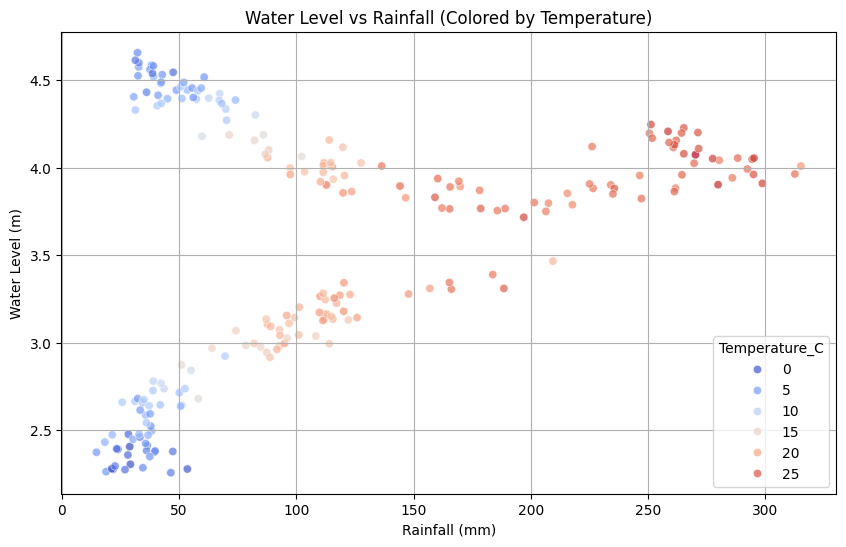

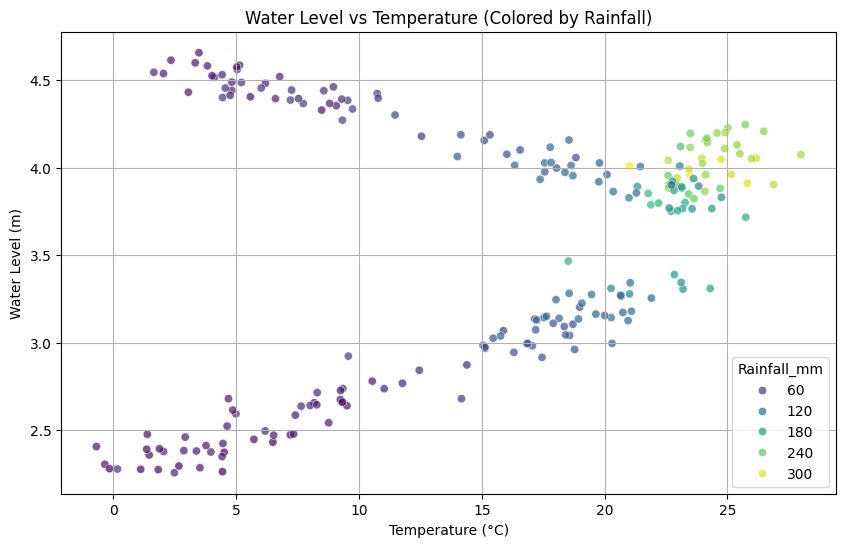

In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb  # Ensure imported if not already
import matplotlib.pyplot as plt
import seaborn as sns

def predict_water_level_with_rainfall_temp(
    dwlr_base: pd.DataFrame,
    add_time_features_fn,
    lin_model,
    xgb_model,
    trained_feature_cols=None,
    station_id_default=0,
    context_rows=1000
):
    """
    User inputs date, rainfall, and temperature; predicts water level and shows temperature sensitivity.
    """
    # 1) Get user inputs
    date_str = input("Enter the date to predict for (YYYY-MM-DD): ").strip()
    try:
        user_date = pd.to_datetime(date_str)
    except Exception:
        print("Invalid date format. Please use YYYY-MM-DD.")
        return

    rainfall_str = input("Enter Rainfall_mm for this date: ").strip()
    try:
        rainfall = float(rainfall_str)
    except ValueError:
        print("Invalid rainfall value. Using 0.")
        rainfall = 0.0

    temp_str = input("Enter Temperature_C for this date: ").strip()
    try:
        temp = float(temp_str)
    except ValueError:
        print("Invalid temperature value. Using 0.")
        temp = 0.0

    # 2) Prepare user row
    user_row = {
        "Date": user_date,
        "station_id": station_id_default,
        "Water_Level_m": np.nan,  # Predict this
        "Rainfall_mm": rainfall,
        "Temperature_C": temp,
        "pH": np.nan,  # Optional, filled from history
        "Dissolved_Oxygen_mg_L": np.nan,
    }

    # 3) Append to historical data
    live = dwlr_base.copy()
    for c in ["Rainfall_mm", "Temperature_C", "pH", "Dissolved_Oxygen_mg_L"]:
        if c not in live.columns:
            live[c] = np.nan
    live = pd.concat([live, pd.DataFrame([user_row])], ignore_index=True)
    live = live.sort_values(["station_id", "Date"]).reset_index(drop=True)

    # 4) Take last N rows for features
    start = max(0, len(live) - context_rows)
    tail_df = live.iloc[start:].copy()

    # 5) Compute features
    tail_feat = add_time_features_fn(tail_df, horizon=0)  # Horizon=0 for same-day prediction

    # 6) Determine feature columns
    if trained_feature_cols is None:
        trained_feature_cols = [c for c in tail_feat.columns if c not in ["Date", "station_id", "target", "Water_Level_m"]]

    # 7) Fill NaNs
    tail_feat[trained_feature_cols] = tail_feat[trained_feature_cols].ffill().bfill()

    # 8) Predict for input temperature
    x_new = tail_feat.iloc[[-1]][trained_feature_cols].to_numpy(dtype='float64')
    pred_lr = lin_model.predict(x_new)[0]
    dnew = xgb.DMatrix(x_new, feature_names=trained_feature_cols)
    pred_xgb = xgb_model.predict(dnew)[0]

    print(f"\nPrediction for {user_date.date()} with Rainfall {rainfall} mm and Temperature {temp} C:")
    print(f"Linear Regression water level (m): {pred_lr:.3f}")
    print(f"XGBoost water level (m): {pred_xgb:.3f}")

    # 9) Show change according to temperature (vary temp, keep rainfall fixed)
    temps = np.linspace(temp - 10, temp + 10, 5)  # Vary around input temp
    predictions = []
    for t in temps:
        temp_row = user_row.copy()
        temp_row["Temperature_C"] = t
        temp_live = pd.concat([dwlr_base.copy(), pd.DataFrame([temp_row])], ignore_index=True)
        temp_live = temp_live.sort_values(["station_id", "Date"]).reset_index(drop=True)
        temp_tail = temp_live.iloc[max(0, len(temp_live) - context_rows):].copy()
        temp_feat = add_time_features_fn(temp_tail, horizon=0)
        temp_feat[trained_feature_cols] = temp_feat[trained_feature_cols].ffill().bfill()
        x_temp = temp_feat.iloc[[-1]][trained_feature_cols].to_numpy(dtype='float64')
        pred_lr_temp = lin_model.predict(x_temp)[0]
        pred_xgb_temp = xgb_model.predict(xgb.DMatrix(x_temp, feature_names=trained_feature_cols))[0]
        predictions.append((t, pred_lr_temp, pred_xgb_temp))

    # Display temperature sensitivity table
    print("\nWater Level Changes with Temperature (Rainfall fixed at", rainfall, "mm):")
    for t, plr, pxgb in predictions:
        print(f"Temperature {t:.1f} C: LR {plr:.3f} m, XGB {pxgb:.3f} m")

# Usage (call after training):
predict_water_level_with_rainfall_temp(
    dwlr_base=dwlr,
    add_time_features_fn=add_time_features,
    lin_model=lin,
    xgb_model=xgb_point,
    trained_feature_cols=X_cols,
    station_id_default=0,
    context_rows=1000
)
# Assuming 'feat' is your featured DataFrame with 'Water_Level_m', 'Rainfall_mm', 'Temperature_C'

# Scatter Plot 1: Water Level vs Rainfall, colored by Temperature
plt.figure(figsize=(10, 6))
sns.scatterplot(data=feat, x='Rainfall_mm', y='Water_Level_m', hue='Temperature_C', palette='coolwarm', alpha=0.7)
plt.title('Water Level vs Rainfall (Colored by Temperature)')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Water Level (m)')
plt.grid(True)
plt.show()

# Scatter Plot 2: Water Level vs Temperature, colored by Rainfall
plt.figure(figsize=(10, 6))
sns.scatterplot(data=feat, x='Temperature_C', y='Water_Level_m', hue='Rainfall_mm', palette='viridis', alpha=0.7)
plt.title('Water Level vs Temperature (Colored by Rainfall)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Water Level (m)')
plt.grid(True)
plt.show()




--- Water Quality Check ---
pH: Poor (4.0 outside 6.5-8.5)
Dissolved Oxygen (mg/L): Skipped (no input)
BOD (mg/L): Skipped (no input)
Nitrate (mg/L): Skipped (no input)
Fecal Coliform (MPN/100ml): Skipped (no input)
Overall Classification: Poor

Historical Averages from Dataset:
Average pH: 7.37


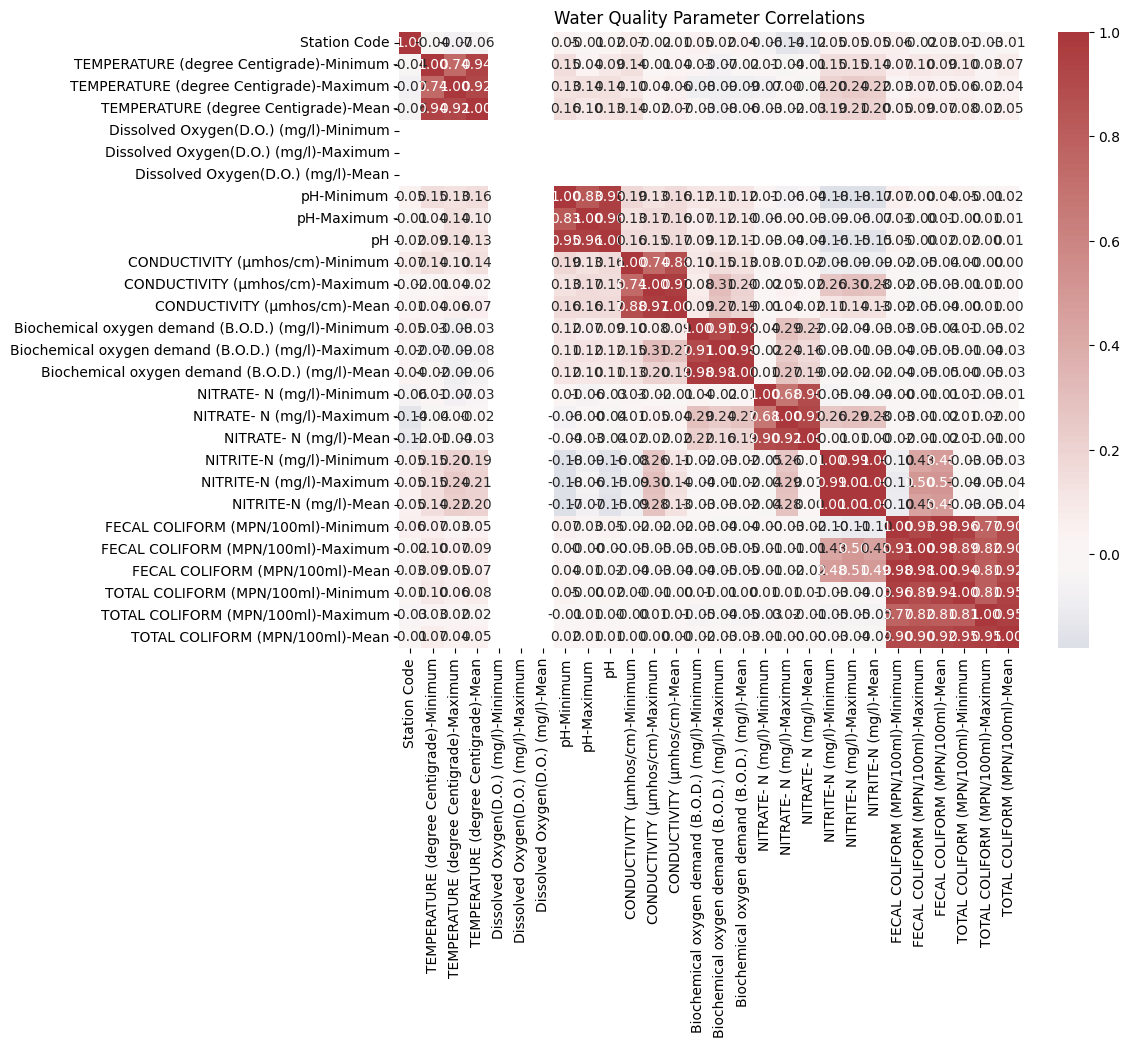

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Standard thresholds (customize as needed; based on WHO/Indian drinking water standards)
THRESHOLDS = {
    'pH': (6.5, 8.5),  # Good range
    'Dissolved Oxygen (mg/L)': (5, np.inf),  # Minimum 5 for good quality
    'BOD (mg/L)': (0, 3),  # Max 3 for good
    'Nitrate (mg/L)': (0, 45),  # Max 45
    'Fecal Coliform (MPN/100ml)': (0, 0)  # Ideally 0
}

def check_water_quality():
    # Load the water quality dataset (adjust path if needed)
    wq_path = 'wtrqlty_grndwtr_2008.csv'
    wq_df = pd.read_csv(wq_path, encoding='latin1')

    # Rename columns for simplicity (based on your file structure)
    wq_df = wq_df.rename(columns={
        'pH-Mean': 'pH',
        'Dissolved OxygenD.O. mgl-Mean': 'Dissolved Oxygen (mg/L)',
        'Biochemical oxygen demand B.O.D. mgl-Mean': 'BOD (mg/L)',
        'NITRATE- N mgl-Mean': 'Nitrate (mg/L)',
        'FECAL COLIFORM MPN100ml-Mean': 'Fecal Coliform (MPN/100ml)'
    })

    # Select relevant columns
    quality_cols = list(THRESHOLDS.keys())

    # 1) User inputs for parameters
    user_inputs = {}
    for param in quality_cols:
        val_str = input(f"Enter {param} value (press Enter to skip): ").strip()
        user_inputs[param] = float(val_str) if val_str else np.nan

    # 2) Check against thresholds and classify
    results = {}
    good_count = 0
    total = len([v for v in user_inputs.values() if not np.isnan(v)])
    for param, val in user_inputs.items():
        if np.isnan(val):
            results[param] = "Skipped (no input)"
            continue
        low, high = THRESHOLDS[param]
        if low <= val <= high:
            results[param] = f"Good ({val} within {low}-{high})"
            good_count += 1
        else:
            results[param] = f"Poor ({val} outside {low}-{high})"

    # Overall classification
    if total == 0:
        classification = "No inputs provided"
    elif good_count / total >= 0.8:
        classification = "Good"
    elif good_count / total >= 0.5:
        classification = "Moderate"
    else:
        classification = "Poor"

    # 3) Display results
    print("\n--- Water Quality Check ---")
    for param, res in results.items():
        print(f"{param}: {res}")
    print(f"Overall Classification: {classification}")

    # 4) Historical statistics from dataset for context
    print("\nHistorical Averages from Dataset:")
    for param in quality_cols:
        if param in wq_df.columns:
            avg = wq_df[param].mean()
            print(f"Average {param}: {avg:.2f}")

    # 5) Visualization: Correlation heatmap of quality parameters
    num_cols = [c for c in wq_df.columns if pd.api.types.is_numeric_dtype(wq_df[c])]
    plt.figure(figsize=(10, 8))
    sns.heatmap(wq_df[num_cols].corr(), cmap='vlag', center=0, annot=True, fmt='.2f')
    plt.title('Water Quality Parameter Correlations')
    plt.show()

# Run the checker
check_water_quality()
